In [1]:
%cd ../../../../test/e2e

/home/hoang/Workspace/PRL/other/minhtung0404/cometbft/test/e2e


In [6]:
%cd ../../scripts/qa/reporting/epoch_scripts

/home/hoang/Workspace/PRL/other/minhtung0404/cometbft/scripts/qa/reporting/epoch_scripts


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import subprocess
import os
import json

In [3]:
test_states = 8
iterations = 2

timeout = 300

json_stats = dict()

for n_states in range(1, test_states + 1):
    print(f"---- Starting test of n_states {n_states} ----")

    json_stats[n_states] = []

    with open("networks/simple.toml", "r") as src:
        with open("networks/simple_modified.toml", "w") as dst:
            for l in src:
                if l.startswith("n_states"):
                    dst.write(f"n_states = {n_states}")
                else:
                    dst.write(l)
    
    with open("benchmark.txt", "w") as f:
        f.write("")
    
    success = 0
    for i in range(iterations):
        try:
            subprocess.run(["./build/runner", "-f", "networks/simple_modified.toml", "benchmark"], timeout=timeout)
            success += 1
        except:
            print(f"Timing out after {timeout}s")
            if success == 0 and i == iterations - 1:
                i -= 1

    with open("benchmark.txt", "r") as f:
        for l in f:
            json_stats[n_states].append(l)

    print("Updated json_stats")
    print(json_stats)

with open("benchmark_total.txt", "w") as f:
    f.write(json.dumps(json_stats))

---- Starting test of n_states 1 ----
I[2025-05-12|15:31:47.939] Removing Docker containers and networks      
I[2025-05-12|15:31:48.065] cleanup dir                                  msg="Removing testnet directory `networks/simple_modified`"
I[2025-05-12|15:31:48.354] setup                                        msg="Generating testnet files in `networks/simple_modified`"
I[2025-05-12|15:31:48.386] Starting initial network nodes...            
I[2025-05-12|15:31:48.387] load                                         msg="Starting transaction load (16 workers)..."
E[2025-05-12|15:31:48.391] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5704/v1\": dial tcp 127.0.0.1:5704: connect: connection refused"
E[2025-05-12|15:31:48.391] failed to send transaction                   err="failed request: Post \"http://127.0.0.1:5710/v1\": dial tcp 127.0.0.1:5710: connect: connection refused"
D[2025-05-12|15:31:48.391] load                                    

In [4]:
mean_times = dict()
max_times = dict()
min_times = dict()

for n_states, stats in json_stats.items():
    mean_times[n_states] = 0
    max_times[n_states] = -1000
    min_times[n_states] = 1000

    for json_stat in stats:
        stat = json.loads(json_stat)
        mean_times[n_states] += stat["mean"]
        max_times[n_states] = max(max_times[n_states], stat["max"])
        min_times[n_states] = min(min_times[n_states], stat["min"])
    mean_times[n_states] /= len(stats)

    print(f"Stats for {n_states}: Mean {mean_times[n_states]} max {max_times[n_states]} min {min_times[n_states]}")

print(f"Stats for all {len(mean_times)} tests")
for n_states in mean_times:
    print(f"Stats for {n_states}: Mean {mean_times[n_states]} max {max_times[n_states]} min {min_times[n_states]}")

Stats for 1: Mean 1.597363163 max 1.972874448 min 1.480424397
Stats for 2: Mean 0.781067984 max 1.443381969 min 0.133996993
Stats for 3: Mean 0.5652114745 max 1.377937515 min 0.089370269
Stats for 4: Mean 0.469976806 max 1.645224671 min 0.027646365
Stats for 5: Mean 0.44932954599999997 max 1.856302066 min 0.081929047
Stats for 6: Mean 0.447086897 max 2.074443287 min 0.083812377
Stats for 7: Mean 0.457850205 max 2.772683996 min 0.000491818
Stats for 8: Mean 0.4293387985 max 2.612531893 min 0.017280828
Stats for all 8 tests
Stats for 1: Mean 1.597363163 max 1.972874448 min 1.480424397
Stats for 2: Mean 0.781067984 max 1.443381969 min 0.133996993
Stats for 3: Mean 0.5652114745 max 1.377937515 min 0.089370269
Stats for 4: Mean 0.469976806 max 1.645224671 min 0.027646365
Stats for 5: Mean 0.44932954599999997 max 1.856302066 min 0.081929047
Stats for 6: Mean 0.447086897 max 2.074443287 min 0.083812377
Stats for 7: Mean 0.457850205 max 2.772683996 min 0.000491818
Stats for 8: Mean 0.429338798

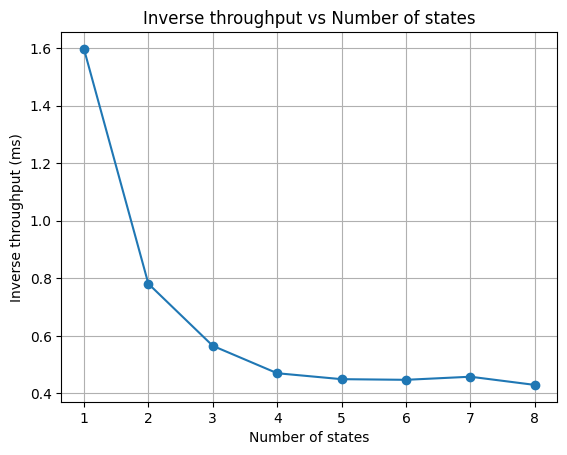

In [7]:
# plotting inv_throughput

plt.plot(mean_times.keys(), mean_times.values(), marker='o')
plt.xlabel("Number of states")
plt.ylabel("Inverse throughput (ms)")
plt.title("Inverse throughput vs Number of states")
plt.xticks(range(1, len(mean_times) + 1), range(1, len(mean_times) + 1))
plt.grid()
plt.savefig("inv_throughput.png")
plt.show()

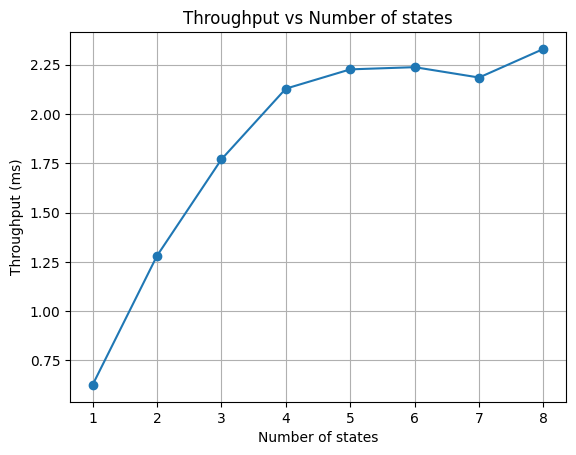

In [8]:
throughput = dict()
for n_states in mean_times:
    throughput[n_states] = 1 / mean_times[n_states]

plt.plot(throughput.keys(), throughput.values(), marker='o')
plt.xlabel("Number of states")
plt.ylabel("Throughput (ms)")
plt.title("Throughput vs Number of states")
plt.xticks(range(1, len(throughput) + 1), range(1, len(throughput) + 1))
plt.grid()
plt.savefig("throughput_vs_nstates.png")
plt.show()